In [4]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()
import openl3
import soundfile as sf
# import sounddevice as sd
from openl3.core import _preprocess_audio_batch
from kapre.time_frequency import Spectrogram, Melspectrogram
from keras.layers import Input
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from librosa import display
import os
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1198487862980203115,
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4805853522581612339
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17696544410010943651
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22675859047
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 6976490941923898186
 physical_device_desc: "device: 0, name: Tesla P40, pci bus id: 0000:85:00.0, compute capability: 6.1"]

In [67]:
# Read in a single example
audio, sr = sf.read("/scratch/prs392/incubator/data/LibriSpeech/train-clean-360/6567/53342/6567-53342-0017.flac")
# sr = sample rate = # of samples per second
# audio = data for each sample 
#sd.play(audio, sr)
#status = sd.wait()

In [68]:
# Pre-process with padding, centering, hop size, etc. 
audio_prep = _preprocess_audio_batch(audio, sr, center=False, hop_size=0.1)

In [69]:
print("Original audio: ", audio.shape) # samples (one channel)
print("Preprocessed audio: ", audio_prep.shape) # number of frames x channels x samples per frame
# Note: number of frames x samples per frame > original number of samples in audio because
#      1) frames overlap, and
#      2) preprocessing function upsamples to sr of 48000

Original audio:  (253120,)
Preprocessed audio:  (150, 1, 48000)


In [77]:
# Parameters for mel spectrogram transformation
# From _construct_mel256_audio_network at https://github.com/marl/openl3/blob/master/openl3/models.py
weight_decay = 1e-5
n_dft = 2048
n_mels = 128
n_hop = 242
asr = 48000
audio_window_dur = 1
# Do the mel spectrogram transformation
sess = tf.Session()
with sess.as_default():
    audio_mel = Melspectrogram(n_dft=n_dft, n_hop=n_hop, n_mels=n_mels,
                              sr=asr, power_melgram=1.0, htk=True, # n_win=n_win,
                              return_decibel_melgram=True, padding='same')(tf.keras.backend.variable(audio_prep))

In [78]:
print("Mel spectrogram: ", audio_mel.shape)

Mel spectrogram:  (150, 128, 199, 1)


In [79]:
# path = '/home/prs392/codes/incubator/non-invertible-audio-feature-generation/development/param/openl3_librispeech/data_loader/test.npy'
# with open(path, 'rb') as f:
#     a = np.load(f)

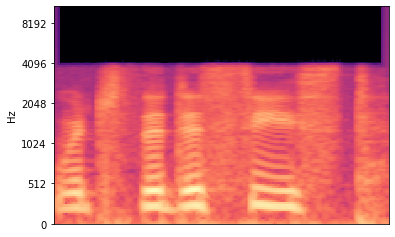

In [80]:
display.specshow(audio_mel[129][:, :, 0].numpy(), y_axis='mel', sr=sr)

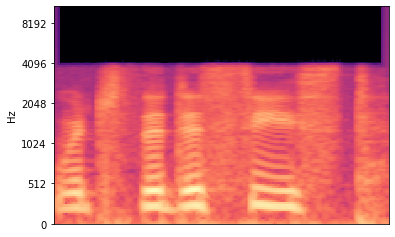

In [81]:
# display.specshow(a[129][:, :, 0], y_axis='mel', sr=sr)

In [82]:
# audio_mel[129]

<tf.Tensor: id=767, shape=(128, 199, 1), dtype=float32, numpy=
array([[[-24.366283],
        [-24.89733 ],
        [-28.468994],
        ...,
        [-16.68412 ],
        [-16.42677 ],
        [-17.182884]],

       [[-24.674248],
        [-24.077463],
        [-23.873432],
        ...,
        [-16.926495],
        [-17.048637],
        [-18.077747]],

       [[-26.234722],
        [-24.4175  ],
        [-22.937603],
        ...,
        [-18.359169],
        [-18.699173],
        [-19.843174]],

       ...,

       [[-51.713028],
        [-52.54937 ],
        [-54.902412],
        ...,
        [-51.03468 ],
        [-48.68947 ],
        [-47.858532]],

       [[-51.73312 ],
        [-52.569454],
        [-54.922474],
        ...,
        [-51.05353 ],
        [-48.708317],
        [-47.87738 ]],

       [[-51.74547 ],
        [-52.581806],
        [-54.93483 ],
        ...,
        [-51.06514 ],
        [-48.719917],
        [-47.88898 ]]], dtype=float32)>

In [83]:
# a[129]

array([[[-24.366283],
        [-24.897327],
        [-28.46899 ],
        ...,
        [-16.68412 ],
        [-16.42677 ],
        [-17.182884]],

       [[-24.674246],
        [-24.077461],
        [-23.87343 ],
        ...,
        [-16.926495],
        [-17.048637],
        [-18.077747]],

       [[-26.234718],
        [-24.417498],
        [-22.937601],
        ...,
        [-18.359167],
        [-18.69917 ],
        [-19.84317 ]],

       ...,

       [[-51.713028],
        [-52.54937 ],
        [-54.902412],
        ...,
        [-51.03468 ],
        [-48.68947 ],
        [-47.858532]],

       [[-51.733116],
        [-52.56945 ],
        [-54.922474],
        ...,
        [-51.053528],
        [-48.708317],
        [-47.877377]],

       [[-51.745464],
        [-52.581806],
        [-54.93483 ],
        ...,
        [-51.065136],
        [-48.719917],
        [-47.888977]]], dtype=float32)

In [43]:
# Read in saved spectrogram
path = "/scratch/bs3743/audio_embeddings/LibriSpeech/spectrograms/8113-117384-0007.npy"
print(os.path.getsize(path))
with open(path, 'rb+') as f:
    audio_mel = np.load(f)
audio_mel

14570112


array([[[[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-22.380451 ],
         [-22.788582 ],
         [-24.320303 ]],

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-24.238796 ],
         [-23.759157 ],
         [-23.680496 ]],

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-26.803087 ],
         [-24.793392 ],
         [-23.742044 ]],

        ...,

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-53.00068  ],
         [-50.652493 ],
         [-49.819504 ]],

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-53.03651  ],
         [-50.68803  ],
         [-49.855133 ]],

        [[-80.       ],
         [-80.       ],
         [-80.       ],
         ...,
         [-53.058556 ],
         [-50.71027  ],
         [-49.877243 ]]],


       [[[-80.       ],


In [22]:
audio_mel.shape

TensorShape([Dimension(137), Dimension(256), Dimension(199), Dimension(1)])